## Importation

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Similar to Assignment 1, making a root path to the GitHub repository, then creating paths from there into the dataset folder, and to the attrition dataset file we will be cleaning.

In [2]:
import tarfile
import urllib

dir_path = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/"
data_path = os.path.join(dir_path, "data")
original_file_path = os.path.join(data_path, "hr_attrition.csv")

In [147]:
df = pd.read_csv(original_file_path)
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

## Output Function

**This output is the culmination of the entire notebook**<br>
It's placed up here for convenience

This custom function takes in the dataset, then returns the cleaned version as well as an array containing the original values for the two label encoded variables - `JobRole` and `EducationField`

In [148]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def transform(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # giving the original values for education field and job role to be used later, if needed
    inverse_edu_job = data[lab_vars]
    
    df_num = [] # list of numerical variables
    cat_vars = ordinal_vars + ohe_vars + lab_vars
    cat_vars.append('Attrition') # target variable
    for i in list(data.columns):
        if i not in cat_vars:
            df_num.append(i)
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded

    
    # standardizing numerical variables
    num_pipeline = Pipeline([('scaler', StandardScaler())])
    num_std = num_pipeline.fit_transform(data[df_num])
    data[df_num] = num_std
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data, inverse_edu_job

In [149]:
df_transformed, inverse_array = transform(df)
df_transformed.head()

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Age  Attrition  BusinessTravel  DailyRate  DistanceFromHome  \
0  0.544150          1             1.0   0.736047         -1.017625   
1  1.467991          0             2.0  -1.303969         -0.151871   
2  0.082230          1             1.0   1.407790         -0.893946   
3 -0.379691          0             2.0   1.454886         -0.770267   
4 -1.072571          0             1.0  -0.530597         -0.893946   

   Education  EducationField  EmployeeNumber  EnvironmentSatisfaction  \
0        1.0               1       -1.697374                      1.0   
1        0.0               1       -1.695721                      2.0   
2        1.0               4       -1.692414                      3.0   
3        3.0               1       -1.690760                      3.0   
4        0.0               3       -1.687454                      0.0   

   HourlyRate  ...  YearsAtCompany  YearsInCurrentRole  \
0    1.381722  ...       -0.114763           -0.033885   
1   -0.243010  ...        0.630342            0.808486   
2    1.283253  ...       -1.232420           -1.157047   
3   -0.489181  ...        0.257789            0.808486   
4   -1.276930  ...       -0.859867           -0.595466   

   YearsSinceLastPromotion  YearsWithCurrManager  \
0                -0.677222              0.278787   
1                -0.352586              0.850069   
2                -0.677222             -1.149417   
3                 0.296686             -1.149417   
4                -0.027950             -0.578135   

   Department_Research & Development  Department_Sales  Gender_Male  \
0                                  0                 1            0   
1                                  1                 0            1   
2                                  1                 0            1   
3                                  1                 0            0   
4                                  1                 0            1   

   MaritalStatus_Married  MaritalStatus_Single  OverTime_Yes  
0                      0                     1             1  
1                      1                     0             0  
2                      0                     1             1  
3                      1                     0             1  
4                      1                     0             0  

[5 rows x 34 columns]

In [150]:
inverse_array

EducationField                    JobRole
0     Life Sciences            Sales Executive
1     Life Sciences         Research Scientist
2             Other      Laboratory Technician
3     Life Sciences         Research Scientist
4           Medical      Laboratory Technician
...             ...                        ...
1465        Medical      Laboratory Technician
1466        Medical  Healthcare Representative
1467  Life Sciences     Manufacturing Director
1468        Medical            Sales Executive
1469        Medical      Laboratory Technician

[1417 rows x 2 columns]

----

## Data Exploration

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [152]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

No null values in this dataset - no need for imputation, then

References for some of the categorical variables with different values:<br>
- `Education`:
    - 1: Below College
    - 2: College
    - 3: Bachelor
    - 4: Master
    - 5: Doctor
- `EnvironmentSatisfaction`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `JobInvolvement`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `JobSatisfaction`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `PerformanceRating`:
    - 1: Low
    - 2: Good
    - 3: Excellent
    - 4: Outstanding
- `RelationshipSatisfaction`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `WorkLifeBalance`:
    - 1: Bad
    - 2: Good
    - 3: Better
    - 4: Best

In [8]:
df.describe()[df.describe().columns[:9]]

Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  
count     1470.000000              1470.000000  1470.000000     1470.000000  
mean      1024.865306                 2.721769    65.891156        2.729932  
std        602.024335                 1.093082    20.329428        0.711561  
min          1.000000                 1.000000    30.000000        1.000000  
25%        491.250000                 2.000000    48.000000        2.000000  
50%       1020.500000                 3.000000    66.000000        3.000000  
75%       1555.750000                 4.000000    83.750000        3.000000  
max       2068.000000                 4.000000   100.000000        4.000000

In [9]:
df.describe()[df.describe().columns[9:17]]

JobLevel  JobSatisfaction  MonthlyIncome   MonthlyRate  \
count  1470.000000      1470.000000    1470.000000   1470.000000   
mean      2.063946         2.728571    6502.931293  14313.103401   
std       1.106940         1.102846    4707.956783   7117.786044   
min       1.000000         1.000000    1009.000000   2094.000000   
25%       1.000000         2.000000    2911.000000   8047.000000   
50%       2.000000         3.000000    4919.000000  14235.500000   
75%       3.000000         4.000000    8379.000000  20461.500000   
max       5.000000         4.000000   19999.000000  26999.000000   

       NumCompaniesWorked  PercentSalaryHike  PerformanceRating  \
count         1470.000000        1470.000000        1470.000000   
mean             2.693197          15.209524           3.153741   
std              2.498009           3.659938           0.360824   
min              0.000000          11.000000           3.000000   
25%              1.000000          12.000000           3.000000   
50%              2.000000          14.000000           3.000000   
75%              4.000000          18.000000           3.000000   
max              9.000000          25.000000           4.000000   

       RelationshipSatisfaction  
count               1470.000000  
mean                   2.712245  
std                    1.081209  
min                    1.000000  
25%                    2.000000  
50%                    3.000000  
75%                    4.000000  
max                    4.000000

In [10]:
df.describe()[df.describe().columns[17:]]

StandardHours  StockOptionLevel  TotalWorkingYears  \
count         1470.0       1470.000000        1470.000000   
mean            80.0          0.793878          11.279592   
std              0.0          0.852077           7.780782   
min             80.0          0.000000           0.000000   
25%             80.0          0.000000           6.000000   
50%             80.0          1.000000          10.000000   
75%             80.0          1.000000          15.000000   
max             80.0          3.000000          40.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count            1470.000000      1470.000000     1470.000000   
mean                2.799320         2.761224        7.008163   
std                 1.289271         0.706476        6.126525   
min                 0.000000         1.000000        0.000000   
25%                 2.000000         2.000000        3.000000   
50%                 3.000000         3.000000        5.000000   
75%                 3.000000         3.000000        9.000000   
max                 6.000000         4.000000       40.000000   

       YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
count         1470.000000              1470.000000           1470.000000  
mean             4.229252                 2.187755              4.123129  
std              3.623137                 3.222430              3.568136  
min              0.000000                 0.000000              0.000000  
25%              2.000000                 0.000000              2.000000  
50%              3.000000                 1.000000              3.000000  
75%              7.000000                 3.000000              7.000000  
max             18.000000                15.000000             17.000000

Right away, we can see that `StandardHours` and `EmployeeCount` have been standardized to a uniform level. We can drop these without losing any information.

In [154]:
df = df.drop(['EmployeeCount', 'StandardHours'], axis = 'columns')

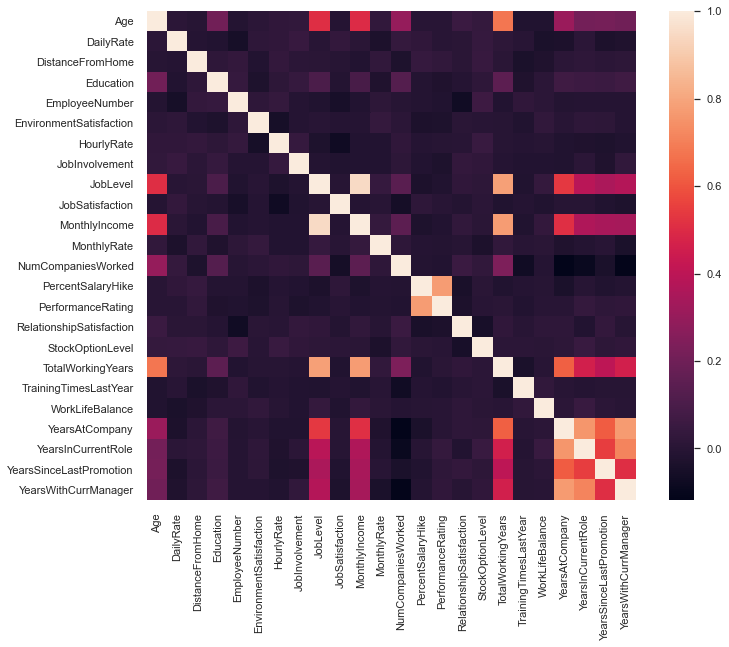

In [155]:
# Correlation

import seaborn as sns

corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

Some of the variables are clearly categorical, but were not given descriptions in the data dictionary. A list of all the numerical variables which appear categorical is as follows:
- `Education`
- `EnvironmentSatisfaction`
- `JobInvolvement`
- `JobLevel`
- `JobSatisfaction`
- `PerformanceRating`
- `RelationshipSatisfaction`
- `StockOptionLevel`
- `WorkLifeBalance`

Each of these variables seem to be ordinal (higher number is better). Ordinal Encoding can be used on these.

#### Non-numeric Columns

In [12]:
# listing the variables not included in the describe() function - not numerical
desc_cols = list(df.describe().columns)
df_cols = list(df.columns)

df[list(np.setdiff1d(df_cols, desc_cols))]

Attrition     BusinessTravel              Department EducationField  \
0          Yes      Travel_Rarely                   Sales  Life Sciences   
1           No  Travel_Frequently  Research & Development  Life Sciences   
2          Yes      Travel_Rarely  Research & Development          Other   
3           No  Travel_Frequently  Research & Development  Life Sciences   
4           No      Travel_Rarely  Research & Development        Medical   
...        ...                ...                     ...            ...   
1465        No  Travel_Frequently  Research & Development        Medical   
1466        No      Travel_Rarely  Research & Development        Medical   
1467        No      Travel_Rarely  Research & Development  Life Sciences   
1468        No  Travel_Frequently                   Sales        Medical   
1469        No      Travel_Rarely  Research & Development        Medical   

      Gender                    JobRole MaritalStatus Over18 OverTime  
0     Female            Sales Executive        Single      Y      Yes  
1       Male         Research Scientist       Married      Y       No  
2       Male      Laboratory Technician        Single      Y      Yes  
3     Female         Research Scientist       Married      Y      Yes  
4       Male      Laboratory Technician       Married      Y       No  
...      ...                        ...           ...    ...      ...  
1465    Male      Laboratory Technician       Married      Y       No  
1466    Male  Healthcare Representative       Married      Y       No  
1467    Male     Manufacturing Director       Married      Y      Yes  
1468    Male            Sales Executive       Married      Y       No  
1469    Male      Laboratory Technician       Married      Y       No  

[1470 rows x 9 columns]

In [13]:
df['Over18'].value_counts()

Y    1470
Name: Over18, dtype: int64

In [14]:
# dropping Over18 - useless variable here
df = df.drop('Over18', axis = 'columns')

In [15]:
df['BusinessTravel'].value_counts()

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

In [16]:
df['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

In [17]:
df['EducationField'].value_counts()

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

In [18]:
df['Gender'].value_counts()

Male      882
Female    588
Name: Gender, dtype: int64

In [19]:
df['JobRole'].value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

In [20]:
df['MaritalStatus'].value_counts()

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

In [21]:
df['OverTime'].value_counts()

No     1054
Yes     416
Name: OverTime, dtype: int64

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

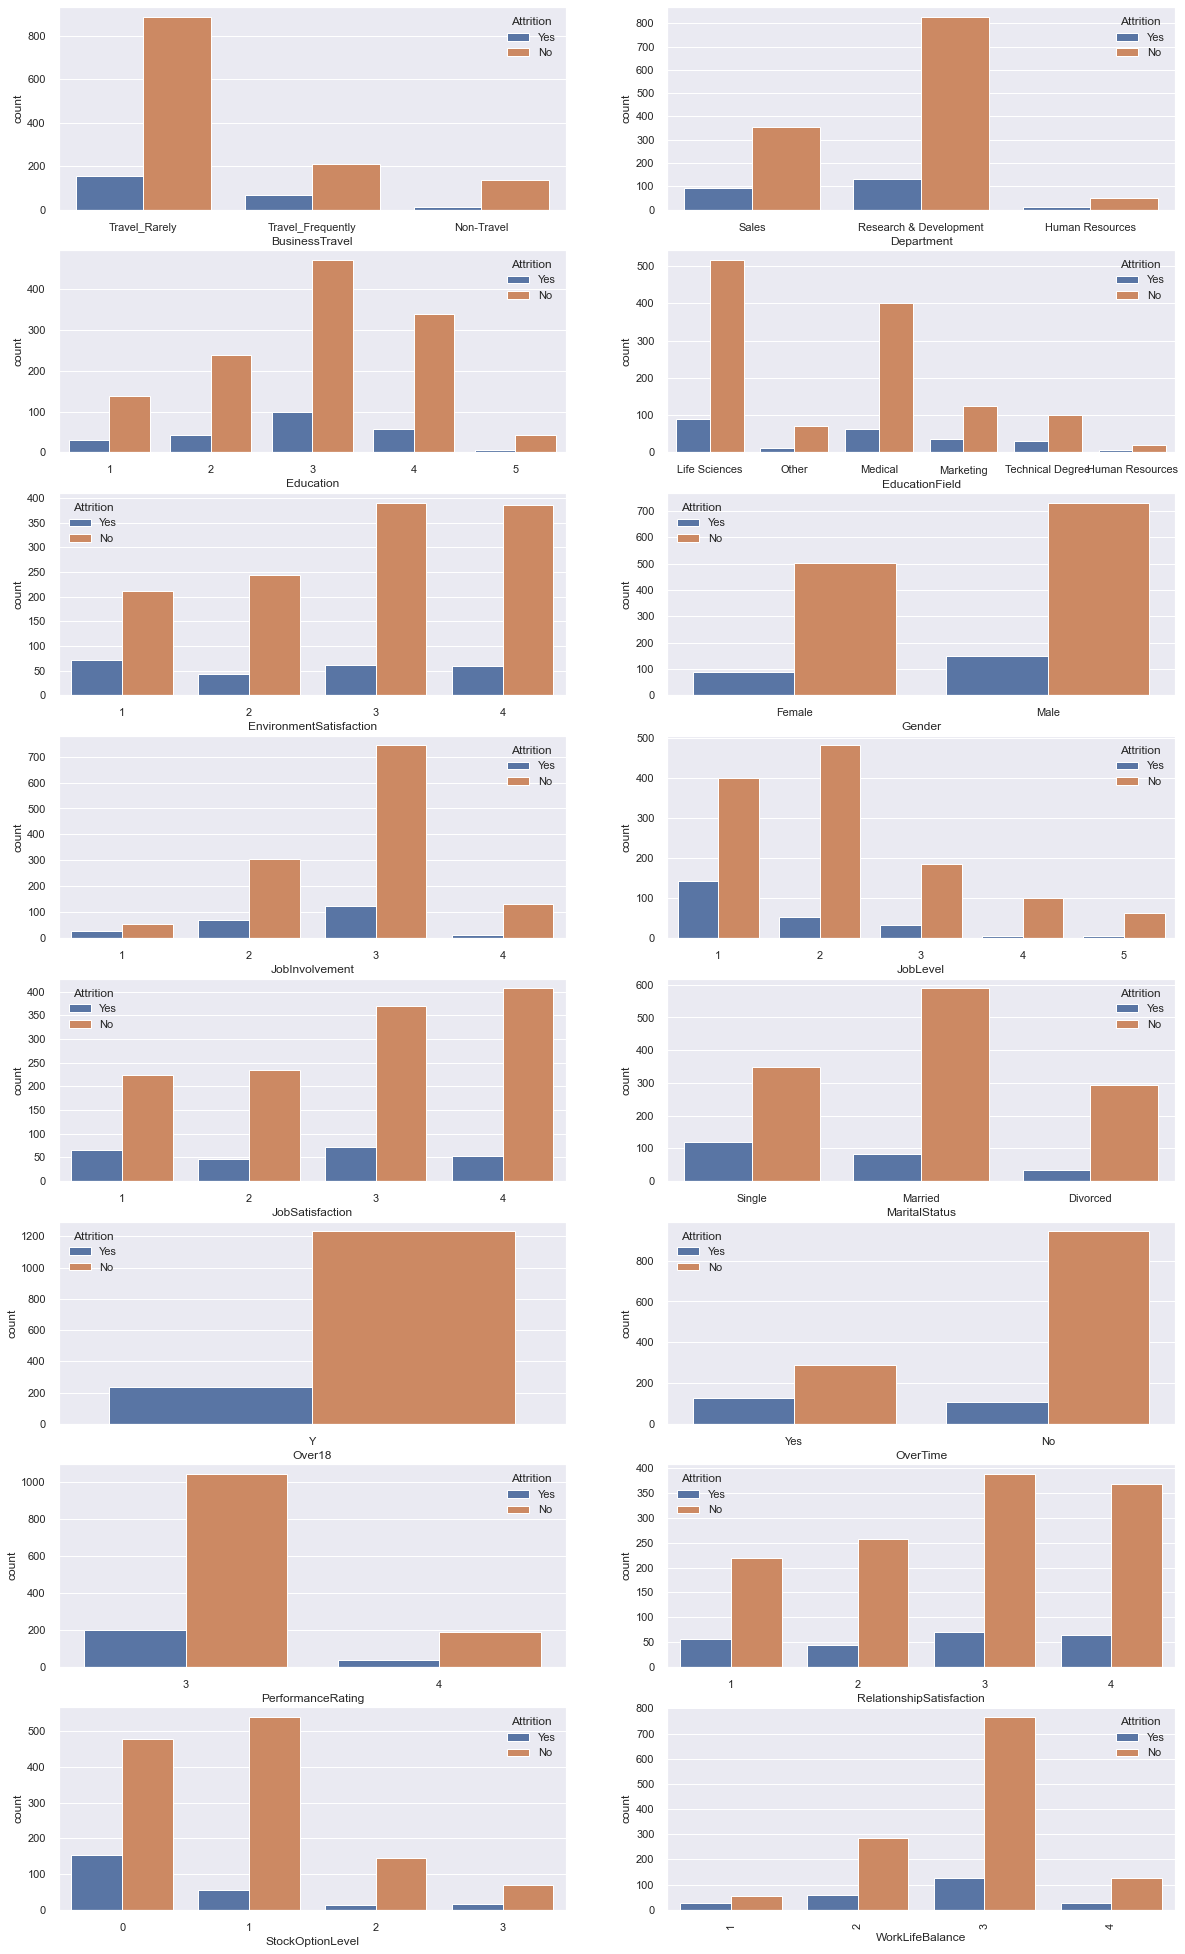

In [200]:
cate = ['BusinessTravel','Department','Education', 'EducationField','EnvironmentSatisfaction', 'Gender',
       'JobInvolvement','JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus','Over18','OverTime', 
       'PerformanceRating','RelationshipSatisfaction', 'StockOptionLevel','WorkLifeBalance']

f, axes = plt.subplots(8,2, figsize=(20,35))

sns.countplot(x='BusinessTravel',hue='Attrition',ax=axes[0,0],data=df)
sns.countplot(x='Department',hue='Attrition',ax=axes[0,1],data=df)
sns.countplot(x='Education',hue='Attrition',ax=axes[1,0],data=df)
sns.countplot(x='EducationField',hue='Attrition',ax=axes[1,1],data=df)
sns.countplot(x='EnvironmentSatisfaction',hue='Attrition',ax=axes[2,0],data=df)
sns.countplot(x='Gender',hue='Attrition',ax=axes[2,1],data=df)
sns.countplot(x='JobInvolvement',hue='Attrition',ax=axes[3,0],data=df)
sns.countplot(x='JobLevel',hue='Attrition',ax=axes[3,1],data=df)
sns.countplot(x='JobSatisfaction',hue='Attrition',ax=axes[4,0],data=df)
sns.countplot(x='MaritalStatus',hue='Attrition',ax=axes[4,1],data=df)
sns.countplot(x='Over18',hue='Attrition',ax=axes[5,0],data=df)
sns.countplot(x='OverTime',hue='Attrition',ax=axes[5,1],data=df)
sns.countplot(x='PerformanceRating',hue='Attrition',ax=axes[6,0],data=df)
sns.countplot(x='RelationshipSatisfaction',hue='Attrition',ax=axes[6,1],data=df)
sns.countplot(x='StockOptionLevel',hue='Attrition',ax=axes[7,0],data=df)
sns.countplot(x='WorkLifeBalance',hue='Attrition',ax=axes[7,1],data=df)


plt.xticks(rotation=90)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Sales Executive'),
  Text(1, 0, 'Research Scientist'),
  Text(2, 0, 'Laboratory Technician'),
  Text(3, 0, 'Manufacturing Director'),
  Text(4, 0, 'Healthcare Representative'),
  Text(5, 0, 'Manager'),
  Text(6, 0, 'Sales Representative'),
  Text(7, 0, 'Research Director'),
  Text(8, 0, 'Human Resources')])

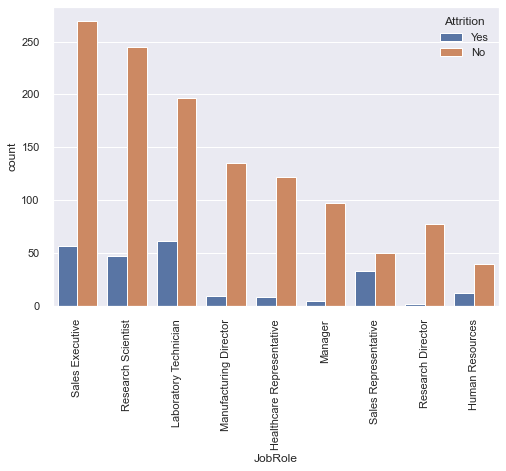

In [199]:
sns.countplot(x='JobRole',hue='Attrition',data=df)
plt.xticks(rotation=90)

#### Histogram of all numerical variables

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matpl

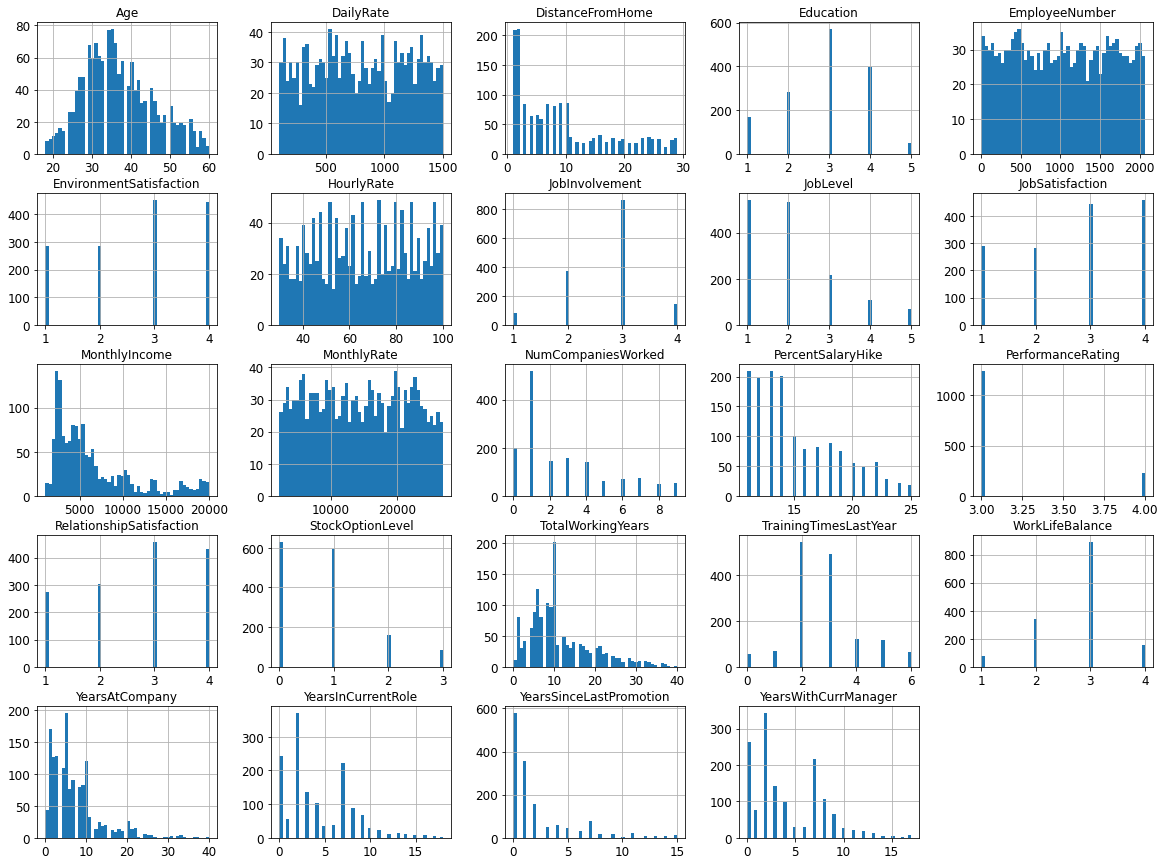

In [22]:
df.hist(bins=50, figsize=(20,15))
plt.show()

# Dorothy: I don't think the graph below is very helpful. We can decide whether we want to delete it.

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


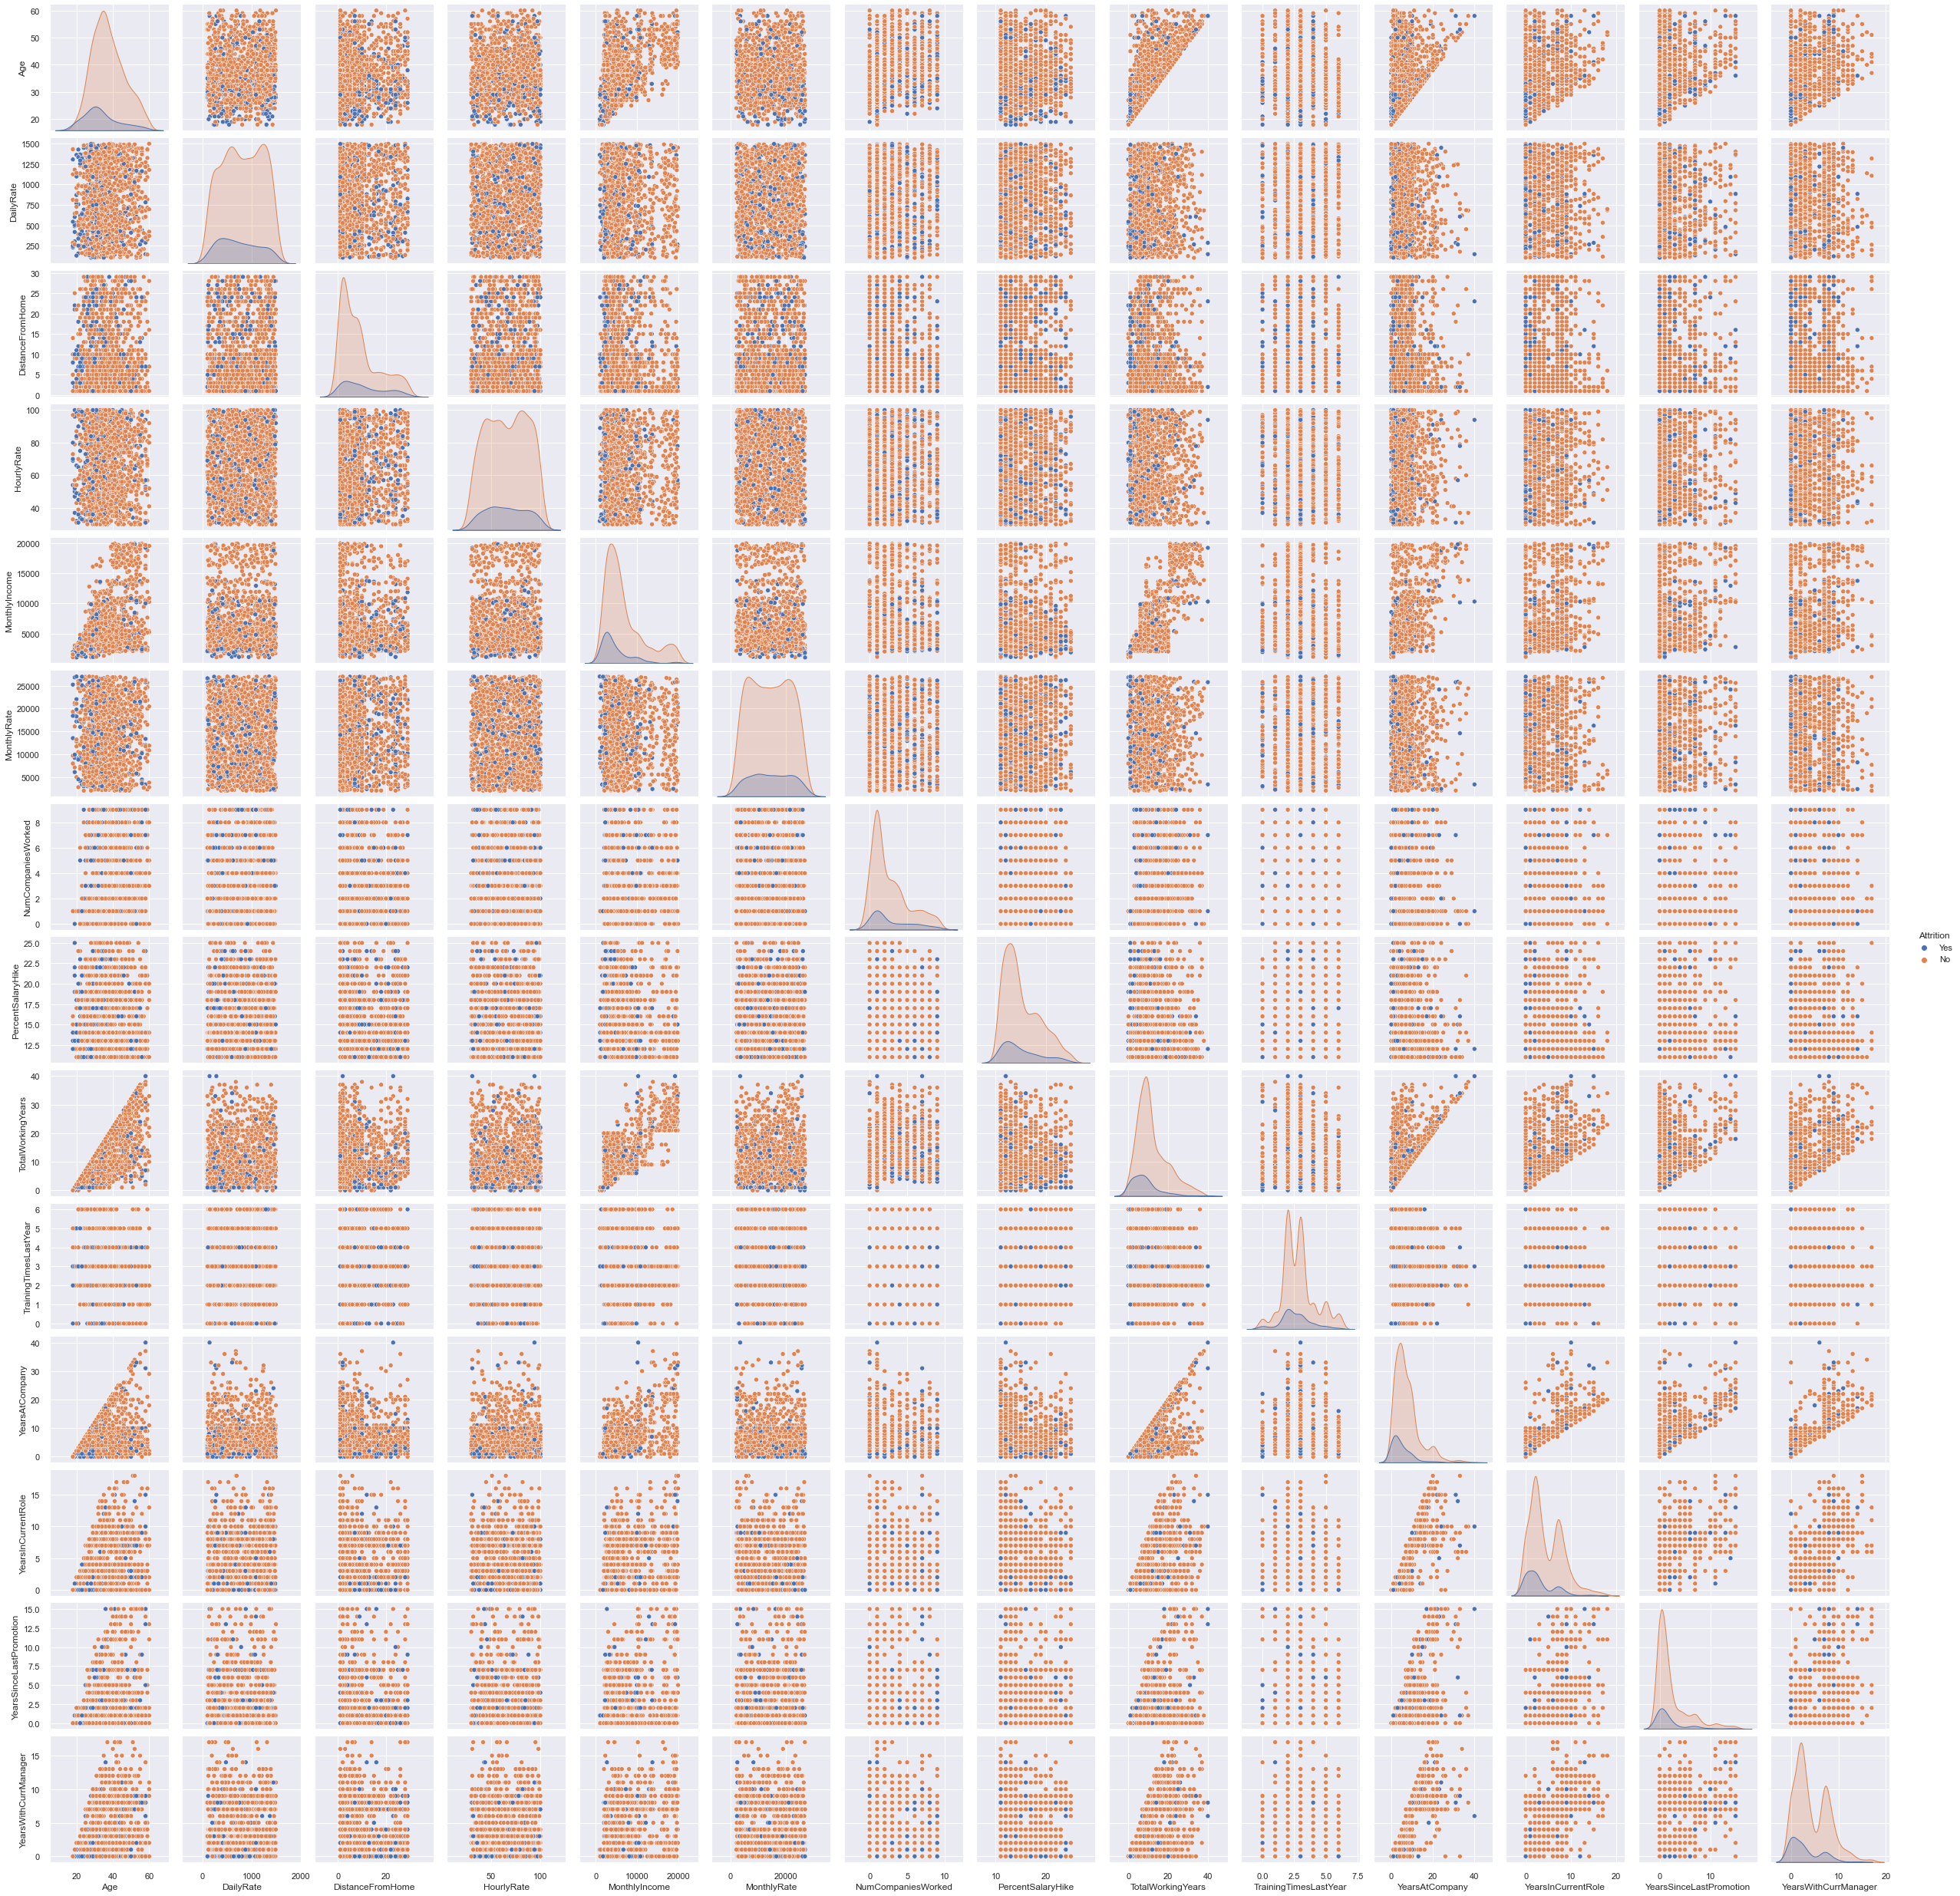

In [208]:
#scatterplot

num_var = ['Attrition', 'Age','DailyRate','DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
          'PercentSalaryHike', 'TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsInCurrentRole', 
           'YearsSinceLastPromotion','YearsWithCurrManager']

df_num = df[num_var]


sns.set()
cols = num_var
sns.pairplot(df_num,hue='Attrition', size = 2.5)
plt.show()

## Encoding Variables

The first hurdle in preparing this dataset is going to be encoding all the categorical variables. There are a number of variables which can be encoded ordinally (namely the numerical ones above). Others cannot be, and may need to be dealt with using other methods (like one hot or label encoding).

#### Ordinal Encoding

In [9]:
# variables which can be dealt with using ordinal encoding
ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
# business travel is currently input as a string array - changing to numerical values
df['BusinessTravel'] = df['BusinessTravel'].replace('Non-Travel', 0)
df['BusinessTravel'] = df['BusinessTravel'].replace('Travel_Rarely', 1)
df['BusinessTravel'] = df['BusinessTravel'].replace('Travel_Frequently', 2)

In [10]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
ordinal_vars_encoded = ord_enc.fit_transform(df[ordinal_vars])
ordinal_vars_encoded[:5]

array([[1., 1., 1., 2., 1., 3., 0., 0., 0., 0.],
       [2., 0., 2., 1., 1., 1., 1., 3., 1., 2.],
       [1., 1., 3., 1., 0., 2., 0., 1., 0., 2.],
       [2., 3., 3., 2., 0., 2., 0., 2., 0., 2.],
       [1., 0., 0., 2., 0., 1., 0., 3., 1., 2.]])

Next up is to deal with categorical variables which are not ordinal. The list of these such variables is as follows:
- `Attrition` (**Target Variable**)
- `Department`
- `EducationField`
- `Gender`
- `JobRole`
- `MaritalStatus`
- `OverTime`

In [11]:
other_vars = ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
# number of unique values in each of these fields
for i in other_vars:
    print(i + ": " + str(df[i].nunique()))

Department: 3
EducationField: 6
Gender: 2
JobRole: 9
MaritalStatus: 3
OverTime: 2


#### One Hot Encoding

Department, gender, marital status, and overtime can use one hot encoding since there are very few unique values in those categories. <br>
Education field and job role should use label encoding since they are high cardinality nominal data fields.

In [12]:
ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe_vars_encoded = ohe.fit_transform(df[ohe_vars])
ohe_vars_encoded = ohe_vars_encoded.toarray()
ohe_vars_encoded[:5]

array([[0., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.]])

In [13]:
ohe.categories_

[array(['Human Resources', 'Research & Development', 'Sales'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Divorced', 'Married', 'Single'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

#### Label Encoding

In [14]:
# label encoding
lab_vars = ['EducationField', 'JobRole']
from sklearn.preprocessing import LabelEncoder
lbl_edu = LabelEncoder()
edu_encoded = lbl_edu.fit_transform(df[['EducationField']])

lbl_job = LabelEncoder()
job_encoded = lbl_job.fit_transform(df[['JobRole']])

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
df_test = df.copy()
df_test.head()

Age Attrition  BusinessTravel  DailyRate              Department  \
0   41       Yes               1       1102                   Sales   
1   49        No               2        279  Research & Development   
2   37       Yes               1       1373  Research & Development   
3   33        No               2       1392  Research & Development   
4   27        No               1        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [16]:
df_test = pd.concat([df_test, pd.get_dummies(df_test[ohe_vars], drop_first = True)], axis = 'columns') #easier than sklearn OHE
df_test = df_test.drop(ohe_vars, axis = 1)
df_test['EducationField'] = edu_encoded
df_test['JobRole'] = job_encoded
df_test[ordinal_vars] = ordinal_vars_encoded

df_test.head()

Age Attrition  BusinessTravel  DailyRate  DistanceFromHome  Education  \
0   41       Yes             1.0       1102                 1        1.0   
1   49        No             2.0        279                 8        0.0   
2   37       Yes             1.0       1373                 2        1.0   
3   33        No             2.0       1392                 3        3.0   
4   27        No             1.0        591                 2        0.0   

   EducationField  EmployeeCount  EmployeeNumber  EnvironmentSatisfaction  \
0               1              1               1                      1.0   
1               1              1               2                      2.0   
2               4              1               4                      3.0   
3               1              1               5                      3.0   
4               3              1               7                      0.0   

   ...  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
0  ...               6                   4                        0   
1  ...              10                   7                        1   
2  ...               0                   0                        0   
3  ...               8                   7                        3   
4  ...               2                   2                        2   

   YearsWithCurrManager  Department_Research & Development  Department_Sales  \
0                     5                                  0                 1   
1                     7                                  1                 0   
2                     0                                  1                 0   
3                     0                                  1                 0   
4                     2                                  1                 0   

   Gender_Male  MaritalStatus_Married MaritalStatus_Single  OverTime_Yes  
0            0                      0                    1             1  
1            1                      1                    0             0  
2            1                      0                    1             1  
3            0                      1                    0             1  
4            1                      1                    0             0  

[5 rows x 37 columns]

In [17]:
df_test['Attrition'] = df_test['Attrition'].replace({'Yes': 1, 'No': 0})
df_test.head()

Age  Attrition  BusinessTravel  DailyRate  DistanceFromHome  Education  \
0   41          1             1.0       1102                 1        1.0   
1   49          0             2.0        279                 8        0.0   
2   37          1             1.0       1373                 2        1.0   
3   33          0             2.0       1392                 3        3.0   
4   27          0             1.0        591                 2        0.0   

   EducationField  EmployeeCount  EmployeeNumber  EnvironmentSatisfaction  \
0               1              1               1                      1.0   
1               1              1               2                      2.0   
2               4              1               4                      3.0   
3               1              1               5                      3.0   
4               3              1               7                      0.0   

   ...  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
0  ...               6                   4                        0   
1  ...              10                   7                        1   
2  ...               0                   0                        0   
3  ...               8                   7                        3   
4  ...               2                   2                        2   

   YearsWithCurrManager  Department_Research & Development  Department_Sales  \
0                     5                                  0                 1   
1                     7                                  1                 0   
2                     0                                  1                 0   
3                     0                                  1                 0   
4                     2                                  1                 0   

   Gender_Male  MaritalStatus_Married MaritalStatus_Single  OverTime_Yes  
0            0                      0                    1             1  
1            1                      1                    0             0  
2            1                      0                    1             1  
3            0                      1                    0             1  
4            1                      1                    0             0  

[5 rows x 37 columns]

## Outlier Filtering

Before passing into any models, some outliers must be removed from the dataset. For this, we set limits on the employee years at the company, and total working years. <br>
Age is not limited here, as it could be useful for the company to predict attrition rates considering age (i.e. employees close to retirement are more likely to retire). This can help to decrease the level of surprise when an employee announces their retirement, and could help the company to move on more efficiently.<br>
We do set some limits on the total working years and the years at the company, though. There are long right tails that could skew due to outliers in these categories.

In [18]:
df.describe()[['YearsAtCompany', 'TotalWorkingYears']]

YearsAtCompany  TotalWorkingYears
count     1470.000000        1470.000000
mean         7.008163          11.279592
std          6.126525           7.780782
min          0.000000           0.000000
25%          3.000000           6.000000
50%          5.000000          10.000000
75%          9.000000          15.000000
max         40.000000          40.000000

The dataset is capped at 40 years already for each of these variables, it would appear.

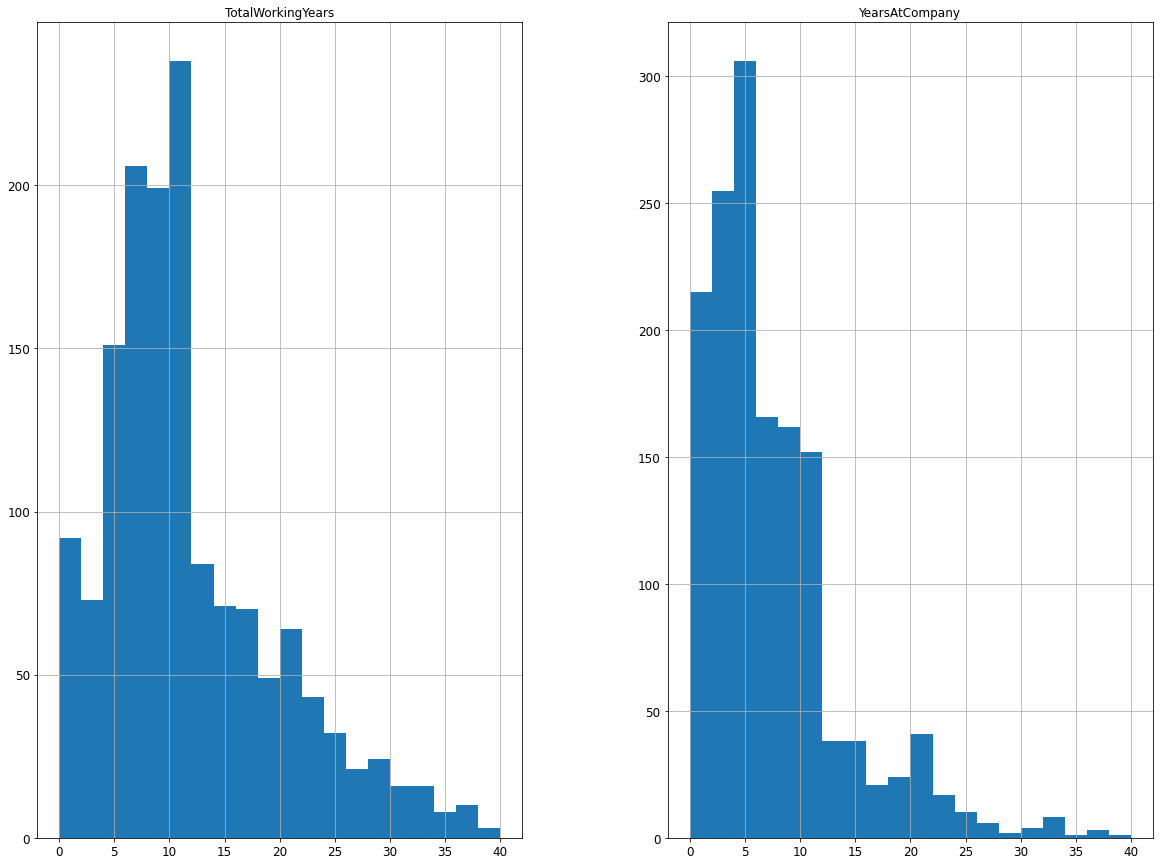

In [33]:
df[['YearsAtCompany', 'TotalWorkingYears']].hist(bins=20, figsize=(20,15))
plt.show()

In [34]:
df['YearsAtCompany'].value_counts()

5     196
1     171
3     128
2     127
10    120
4     110
7      90
9      82
8      80
6      76
0      44
11     32
20     27
13     24
15     20
14     18
22     15
12     14
21     14
18     13
16     12
19     11
17      9
24      6
33      5
25      4
26      4
31      3
32      3
36      2
27      2
29      2
23      2
30      1
34      1
37      1
40      1
Name: YearsAtCompany, dtype: int64

In [35]:
df['TotalWorkingYears'].value_counts()

10    202
6     125
8     103
9      96
5      88
1      81
7      81
4      63
12     48
3      42
15     40
16     37
13     36
11     36
21     34
17     33
14     31
2      31
20     30
18     27
19     22
23     22
22     21
24     18
25     14
28     14
26     14
0      11
29     10
31      9
32      9
27      7
30      7
33      7
36      6
34      5
37      4
35      3
40      2
38      1
Name: TotalWorkingYears, dtype: int64

For each of these variables, we remove observations that have >30 years as there are few of those observations in both categories.

In [36]:
df_filter = df[df['TotalWorkingYears'] < 30]
df_filter = df_filter[df_filter['YearsAtCompany'] < 30]

## Numerical Standardization

Finally the numerical variables must be standardized in order to conduct meaningful analysis.

In [37]:
df_num = []
cat_vars = ordinal_vars + ohe_vars + lab_vars
cat_vars.append('Attrition') # target variable
for i in list(df.columns):
    if i not in cat_vars:
        df_num.append(i)
        
df_num

['Age',
 'DailyRate',
 'DistanceFromHome',
 'EmployeeNumber',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([('scaler', StandardScaler())])
X_std = num_pipeline.fit_transform(df[df_num])
X_std

array([[ 0.4463504 ,  0.74252653, -1.01090934, ..., -0.0632959 ,
        -0.67914568,  0.24583399],
       [ 1.32236521, -1.2977746 , -0.14714972, ...,  0.76499762,
        -0.36871529,  0.80654148],
       [ 0.008343  ,  1.41436324, -0.88751511, ..., -1.16768726,
        -0.67914568, -1.15593471],
       ...,
       [-1.08667552, -1.60518328, -0.64072665, ..., -0.61549158,
        -0.67914568, -0.31487349],
       [ 1.32236521,  0.54667746, -0.88751511, ...,  0.48889978,
        -0.67914568,  1.08689522],
       [-0.32016256, -0.43256792, -0.14714972, ..., -0.33939374,
        -0.36871529, -0.59522723]])

## Additional Outputs

#### Output 1 - Original Dataset <br>
This output is neither encoded nor standardized. It outputs the original dataset with dropped columns and rows as per descriptions above.

In [19]:
def transform_original(data):
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    return data

In [20]:
transform_original(df)

Age Attrition  BusinessTravel  DailyRate              Department  \
0      41       Yes               1       1102                   Sales   
1      49        No               2        279  Research & Development   
2      37       Yes               1       1373  Research & Development   
3      33        No               2       1392  Research & Development   
4      27        No               1        591  Research & Development   
...   ...       ...             ...        ...                     ...   
1465   36        No               2        884  Research & Development   
1466   39        No               1        613  Research & Development   
1467   27        No               1        155  Research & Development   
1468   49        No               2       1023                   Sales   
1469   34        No               1        628  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeNumber  \
0                    1          2  Life Sciences               1   
1                    8          1  Life Sciences               2   
2                    2          2          Other               4   
3                    3          4  Life Sciences               5   
4                    2          1        Medical               7   
...                ...        ...            ...             ...   
1465                23          2        Medical            2061   
1466                 6          1        Medical            2062   
1467                 4          3  Life Sciences            2064   
1468                 2          3        Medical            2065   
1469                 8          3        Medical            2068   

      EnvironmentSatisfaction  ... PerformanceRating  \
0                           2  ...                 3   
1                           3  ...                 4   
2                           4  ...                 3   
3                           4  ...                 3   
4                           1  ...                 3   
...                       ...  ...               ...   
1465                        3  ...                 3   
1466                        4  ...                 3   
1467                        2  ...                 4   
1468                        4  ...                 3   
1469                        2  ...                 3   

      RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
0                            1                 0                  8   
1                            4                 1                 10   
2                            2                 0                  7   
3                            3                 0                  8   
4                            4                 1                  6   
...                        ...               ...                ...   
1465                         3                 1                 17   
1466                         1                 1                  9   
1467                         2                 1                  6   
1468                         4                 0                 17   
1469                         1                 0                  6   

     TrainingTimesLastYear  WorkLifeBalance YearsAtCompany  \
0                        0                1              6   
1                        3                3             10   
2                        3                3              0   
3                        3                3              8   
4                        3                3              2   
...                    ...              ...            ...   
1465                     3                3              5   
1466                     5                3              7   
1467                     0                3              6   
1468                     3                2              9   
1469                     3                4              4   

      YearsInCurrentRole  Yea

#### Output 2 - Standardized and Preprocessed<br>
This is the output from the custom function created at the top of the notebook

In [34]:
df_transformed, inverse_array = transform(df)
df_transformed.head()

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Age  Attrition  BusinessTravel  DailyRate  DistanceFromHome  \
0  0.544150          1             1.0   0.736047         -1.017625   
1  1.467991          0             2.0  -1.303969         -0.151871   
2  0.082230          1             1.0   1.407790         -0.893946   
3 -0.379691          0             2.0   1.454886         -0.770267   
4 -1.072571          0             1.0  -0.530597         -0.893946   

   Education  EducationField  EmployeeNumber  EnvironmentSatisfaction  \
0        1.0               1       -1.697374                      1.0   
1        0.0               1       -1.695721                      2.0   
2        1.0               4       -1.692414                      3.0   
3        3.0               1       -1.690760                      3.0   
4        0.0               3       -1.687454                      0.0   

   HourlyRate  ...  YearsAtCompany  YearsInCurrentRole  \
0    1.381722  ...       -0.114763           -0.033885   
1   -0.243010  ...        0.630342            0.808486   
2    1.283253  ...       -1.232420           -1.157047   
3   -0.489181  ...        0.257789            0.808486   
4   -1.276930  ...       -0.859867           -0.595466   

   YearsSinceLastPromotion  YearsWithCurrManager  \
0                -0.677222              0.278787   
1                -0.352586              0.850069   
2                -0.677222             -1.149417   
3                 0.296686             -1.149417   
4                -0.027950             -0.578135   

   Department_Research & Development  Department_Sales  Gender_Male  \
0                                  0                 1            0   
1                                  1                 0            1   
2                                  1                 0            1   
3                                  1                 0            0   
4                                  1                 0            1   

   MaritalStatus_Married  MaritalStatus_Single  OverTime_Yes  
0                      0                     1             1  
1                      1                     0             0  
2                      0                     1             1  
3                      1                     0             1  
4                      1                     0             0  

[5 rows x 34 columns]

#### Output 3 - Non-standardized and Preprocessed<br>
This output contains the encoded versions of categorical variables, but not the standardized numerical variables

In [46]:
def transform_encoding(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data

In [50]:
transform_encoding(df).head()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Age  Attrition  BusinessTravel  DailyRate  DistanceFromHome  Education  \
0   41          1             1.0       1102                 1        1.0   
1   49          0             2.0        279                 8        0.0   
2   37          1             1.0       1373                 2        1.0   
3   33          0             2.0       1392                 3        3.0   
4   27          0             1.0        591                 2        0.0   

   EducationField  EmployeeNumber  EnvironmentSatisfaction  HourlyRate  ...  \
0               1               1                      1.0          94  ...   
1               1               2                      2.0          61  ...   
2               4               4                      3.0          92  ...   
3               1               5                      3.0          56  ...   
4               3               7                      0.0          40  ...   

   YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
0               6                   4                        0   
1              10                   7                        1   
2               0                   0                        0   
3               8                   7                        3   
4               2                   2                        2   

   YearsWithCurrManager  Department_Research & Development  Department_Sales  \
0                     5                                  0                 1   
1                     7                                  1                 0   
2                     0                                  1                 0   
3                     0                                  1                 0   
4                     2                                  1                 0   

   Gender_Male  MaritalStatus_Married  MaritalStatus_Single  OverTime_Yes  
0            0                      0                     1             1  
1            1                      1                     0             0  
2            1                      0                     1             1  
3            0                      1                     0             1  
4            1                      1                     0             0  

[5 rows x 34 columns]

## Feature Selection

### 1. Collinearity


Using VIF values to find the multi-collinearity between predictors. The threshold is 10.

In [47]:
df_dummied = transform_encoding(df)

df_dummied.shape

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1417, 34)

In [52]:
df_dummied.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Department_Research & Development', 'Department_Sales', 'Gender_Male',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_Yes'],
      dtype='object')

In [126]:
y = df_dummied[['Attrition']]
X = df_dummied.drop(['Attrition'], axis=1)
X.shape

(1417, 33)

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                              feature        VIF
0                                 Age  30.327337
1                      BusinessTravel   5.051268
2                           DailyRate   5.015292
3                    DistanceFromHome   2.325058
4                           Education   4.702632
5                      EducationField   3.954826
6                      EmployeeNumber   3.909419
7             EnvironmentSatisfaction   3.474661
8                          HourlyRate  11.078498
9                      JobInvolvement   6.894343
10                           JobLevel  19.754894
11                            JobRole   8.480365
12                    JobSatisfaction   3.489805
13                      MonthlyIncome  28.412989
14                        MonthlyRate   4.937322
15                 NumCompaniesWorked   2.709389
16                  PercentSalaryHike  35.908372
17                  PerformanceRating   2.640556
18           RelationshipSatisfaction   3.539067
19                  

In [50]:
df['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

Based on the VIF scores and the understanding of columns, we found that the columns with high VIF scores are basically three types: time related, senior-level related, and departments related. The time related columns are `Age`,`TotalWorkingYears`and `YearsAtCompany`. They are strongly correlated becasue if an employee is older, normally his/her have more experience and probably spend more years at the company. The second category is salary related which are `HourlyRate`, `JobLevel`, `MonthlyIncome` and `PercentSalaryHike`. Similar reason to the first category, the higher job level, the more income, higher hourly rate and more salary hike. They are strongly correlated. The last category is the department includes `Department_Research & Development` and `Department_Sales`. They are correlated because they are dummified from the column `Department`. There are three types of departments values: Research & Development, Sales and Human Resources. However, HR only covers 4% while the majority are the other two departments. As the result, these two columns are correlated to each other since their values are highly possible to be the opposite of each other.


### 2. Mutual Information

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot:ylabel='feature'>

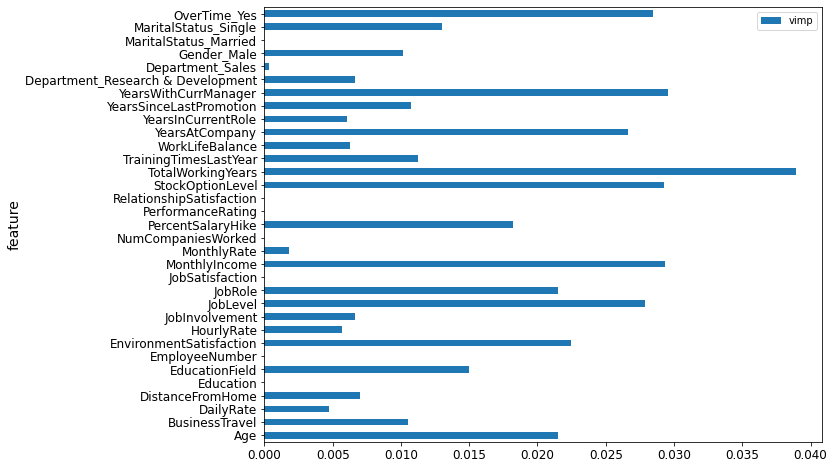

In [54]:
from sklearn import feature_selection

mic = feature_selection.mutual_info_classif(
X, y
)
fig, ax = plt.subplots(figsize=(10, 8))
(
pd.DataFrame(
{"feature": X.columns, "vimp": mic}
)
.set_index("feature")
.plot.barh(ax=ax)
)

With mutual information, the higher scores mean more dependent variables. The result is similar to VIF scores that age-related and job role/level related categories have the higher scores.



### 3. feature importance

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


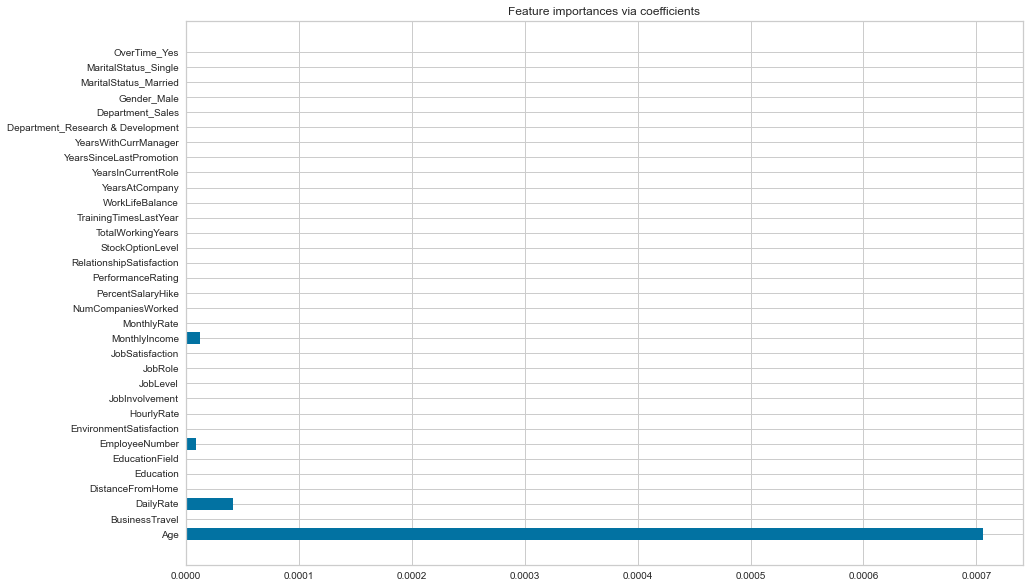

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(X.columns)
plt.figure(figsize=(15,10))
plt.barh(feature_names, importance)
plt.title("Feature importances via coefficients")
plt.show()



### 4. Tree-based Feature Selection

C:\Users\Dorothy Zou\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


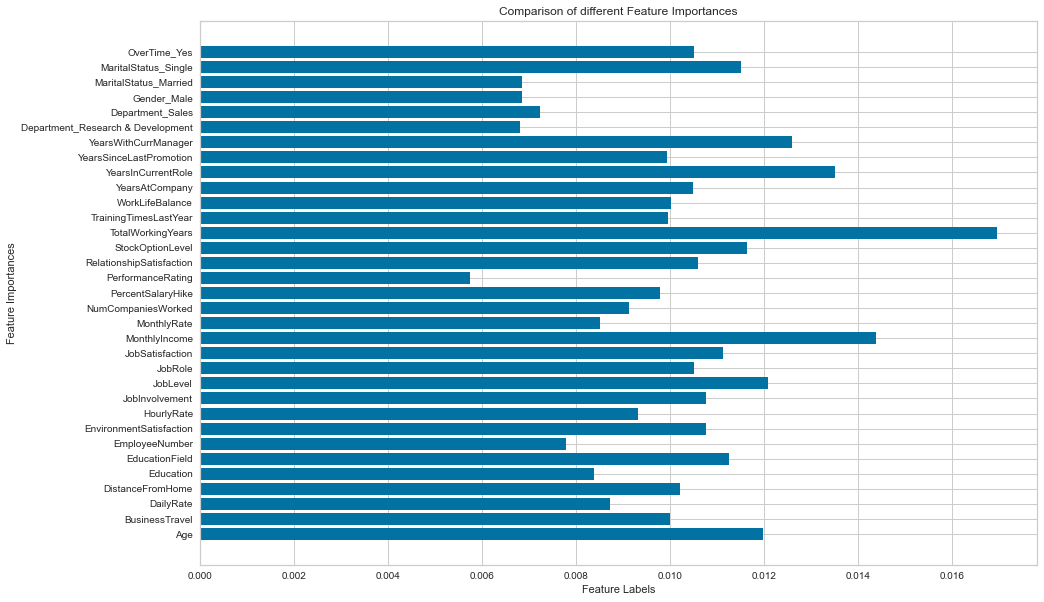

In [122]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
feature_importance = clf.feature_importances_
  
# Normalizing the individual importances 
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0) 

# Plotting a Bar Graph to compare the models 
plt.figure(figsize=(15,10))
plt.barh(X.columns, feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Comparison of different Feature Importances') 
plt.show() 

In [123]:
clf_df = pd.DataFrame(X.columns,columns=['X'])
clf_df['feature_importance']=feature_importance_normalized
clf_df.sort_values(by='feature_importance',ascending=False)

X  feature_importance
20                  TotalWorkingYears            0.016953
13                      MonthlyIncome            0.014377
24                 YearsInCurrentRole            0.013512
26               YearsWithCurrManager            0.012596
10                           JobLevel            0.012074
0                                 Age            0.011968
19                   StockOptionLevel            0.011626
31               MaritalStatus_Single            0.011500
5                      EducationField            0.011243
12                    JobSatisfaction            0.011131
9                      JobInvolvement            0.010762
7             EnvironmentSatisfaction            0.010756
18           RelationshipSatisfaction            0.010580
11                            JobRole            0.010510
32                       OverTime_Yes            0.010504
23                     YearsAtCompany            0.010493
3                    DistanceFromHome            0.010206
22                    WorkLifeBalance            0.010019
1                      BusinessTravel            0.010003
21              TrainingTimesLastYear            0.009962
25            YearsSinceLastPromotion            0.009931
16                  PercentSalaryHike            0.009775
8                          HourlyRate            0.009308
15                 NumCompaniesWorked            0.009128
2                           DailyRate            0.008711
14                        MonthlyRate            0.008513
4                           Education            0.008372
6                      EmployeeNumber            0.007790
28                   Department_Sales            0.007241
29                        Gender_Male            0.006843
30              MaritalStatus_Married            0.006839
27  Department_Research & Development            0.006813
17                  PerformanceRating            0.005752

In [124]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
# df_new = pd.DataFrame(X_new)
# df_new

0       1     2    3    4    5    6       7    8    9     10   11  \
0     41.0  1102.0   1.0  1.0  2.0  1.0  3.0  5993.0  8.0  0.0   8.0  0.0   
1     49.0   279.0   8.0  2.0  1.0  1.0  1.0  5130.0  1.0  3.0  10.0  2.0   
2     37.0  1373.0   2.0  3.0  1.0  0.0  2.0  2090.0  6.0  1.0   7.0  2.0   
3     33.0  1392.0   3.0  3.0  2.0  0.0  2.0  2909.0  1.0  2.0   8.0  2.0   
4     27.0   591.0   2.0  0.0  2.0  0.0  1.0  3468.0  9.0  3.0   6.0  2.0   
...    ...     ...   ...  ...  ...  ...  ...     ...  ...  ...   ...  ...   
1412  36.0   884.0  23.0  2.0  3.0  1.0  3.0  2571.0  4.0  2.0  17.0  2.0   
1413  39.0   613.0   6.0  3.0  1.0  2.0  0.0  9991.0  4.0  0.0   9.0  2.0   
1414  27.0   155.0   4.0  1.0  3.0  1.0  1.0  6142.0  1.0  1.0   6.0  2.0   
1415  49.0  1023.0   2.0  3.0  1.0  1.0  1.0  5390.0  2.0  3.0  17.0  1.0   
1416  34.0   628.0   8.0  1.0  3.0  1.0  2.0  4404.0  2.0  0.0   6.0  3.0   

        12   13   14  
0      6.0  5.0  1.0  
1     10.0  7.0  0.0  
2      0.0  0.0  1.0  
3      8.0  0.0  1.0  
4      2.0  2.0  0.0  
...    ...  ...  ...  
1412   5.0  3.0  0.0  
1413   7.0  7.0  0.0  
1414   6.0  3.0  1.0  
1415   9.0  8.0  0.0  
1416   4.0  2.0  0.0  

[1417 rows x 15 columns]

In [133]:
print("The original predictors have", X.shape[1],'columns, and there are', X_new.shape[1],'columns after feature selection.')

The original predictors have 33 columns, and there are 15 columns after feature selection.


In [129]:
features = pd.DataFrame(X.columns,columns=['Predictors'])
features['Feature selected'] = model.get_support()
features

Predictors  Feature selected
0                                 Age              True
1                      BusinessTravel             False
2                           DailyRate              True
3                    DistanceFromHome              True
4                           Education             False
5                      EducationField             False
6                      EmployeeNumber             False
7             EnvironmentSatisfaction              True
8                          HourlyRate             False
9                      JobInvolvement              True
10                           JobLevel              True
11                            JobRole             False
12                    JobSatisfaction              True
13                      MonthlyIncome              True
14                        MonthlyRate             False
15                 NumCompaniesWorked              True
16                  PercentSalaryHike             False
17                  PerformanceRating             False
18           RelationshipSatisfaction              True
19                   StockOptionLevel             False
20                  TotalWorkingYears              True
21              TrainingTimesLastYear             False
22                    WorkLifeBalance              True
23                     YearsAtCompany              True
24                 YearsInCurrentRole             False
25            YearsSinceLastPromotion             False
26               YearsWithCurrManager              True
27  Department_Research & Development             False
28                   Department_Sales             False
29                        Gender_Male             False
30              MaritalStatus_Married             False
31               MaritalStatus_Single             False
32                       OverTime_Yes              True

In [211]:
features.loc[features['Feature selected']==True]

Predictors  Feature selected
0                        Age              True
2                  DailyRate              True
3           DistanceFromHome              True
7    EnvironmentSatisfaction              True
9             JobInvolvement              True
10                  JobLevel              True
12           JobSatisfaction              True
13             MonthlyIncome              True
15        NumCompaniesWorked              True
18  RelationshipSatisfaction              True
20         TotalWorkingYears              True
22           WorkLifeBalance              True
23            YearsAtCompany              True
26      YearsWithCurrManager              True
32              OverTime_Yes              True